EPI Correction

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def imshow(i):
    plt.imshow(np.concatenate((np.real(i),np.imag(i)),axis=1))
    plt.colorbar()

In [4]:
delay_array = np.random.uniform(-0.5,0.5,(256,1))*np.ones((256,256))

In [5]:
delay_array = delay_array*np.ones((256,256))

In [6]:
def kspace(size: int, calibration: int) -> np.ndarray:
    #drift is the linear row-dependent delay (drift * ky)
    array = np.zeros((size,size),dtype=complex)
    for kx in range(256):
        for ky in range(256):
            measured_kx = kx + delay_array[ky,kx]#*ky
            array[ky,kx] = np.sinc((measured_kx-128)/2)*np.sinc((calibration*(ky-128))/2)
    return array

In [7]:
delay_array

array([[-0.43243465, -0.43243465, -0.43243465, ..., -0.43243465,
        -0.43243465, -0.43243465],
       [ 0.266264  ,  0.266264  ,  0.266264  , ...,  0.266264  ,
         0.266264  ,  0.266264  ],
       [ 0.16817634,  0.16817634,  0.16817634, ...,  0.16817634,
         0.16817634,  0.16817634],
       ...,
       [ 0.08348722,  0.08348722,  0.08348722, ...,  0.08348722,
         0.08348722,  0.08348722],
       [-0.30458816, -0.30458816, -0.30458816, ..., -0.30458816,
        -0.30458816, -0.30458816],
       [-0.37060042, -0.37060042, -0.37060042, ..., -0.37060042,
        -0.37060042, -0.37060042]])

In [8]:
calibration = kspace(256,0)
ifft = np.fft.ifftshift(np.fft.ifft(np.fft.fftshift(calibration), axis = 1))

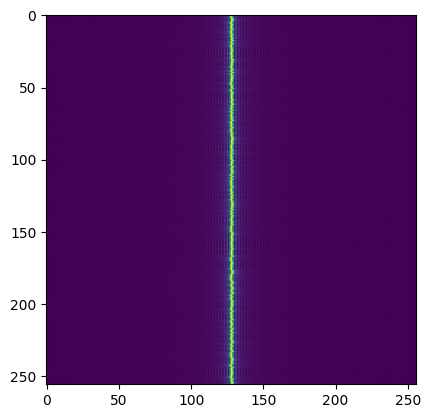

In [9]:
plt.imshow(np.abs(calibration))

In [10]:
calibration

array([[ 0.003114  +0.j, -0.00388686+0.j, -0.00316326+0.j, ...,
         0.00397625+0.j,  0.00318505+0.j, -0.00391342+0.j],
       [-0.00202428+0.j, -0.00459029+0.j,  0.00205648+0.j, ...,
         0.00464407+0.j, -0.0020478 +0.j, -0.00457108+0.j],
       [-0.00130036+0.j, -0.00484527+0.j,  0.00132103+0.j, ...,
         0.00490967+0.j, -0.0013175 +0.j, -0.00483246+0.j],
       ...,
       [-0.0006508 +0.j, -0.00497298+0.j,  0.00066114+0.j, ...,
         0.00504586+0.j, -0.00066026+0.j, -0.00496645+0.j],
       [ 0.00228441+0.j, -0.00443923+0.j, -0.00232058+0.j, ...,
         0.00453212+0.j,  0.00233183+0.j, -0.00446058+0.j],
       [ 0.00272664+0.j, -0.00417492+0.j, -0.00276979+0.j, ...,
         0.00426674+0.j,  0.00278613+0.j, -0.00419935+0.j]])

In [11]:
delay_array[0,0]

-0.4324346465267117

Using atan2

In [12]:
angles = np.arctan2(np.imag(ifft),np.real(np.real(ifft)))
shifted_angles = np.roll(angles, shift = 1, axis = 1)
diff = angles - shifted_angles

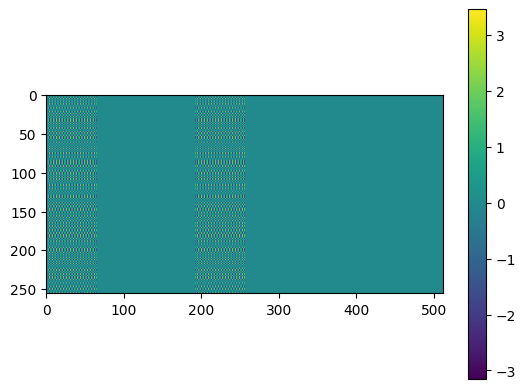

In [13]:
imshow(diff)

In [14]:
#There is an issue using arctan2 because of its implementation. Losing information when using arctan2 (losing magnitude).
#magnitude tells if meaningful angle as part of signal. It turns continuous values into discontinuous values (since it goes from -pi to pi).
#If it crosses negative axis in complex plane, it goes from -pi to pi, or other way around. These are problems with using atan2.

Using Complex Conjugate

In [15]:
#Complex conjugate squares the magnitude - this method is more robust when it comes to considering noise.

In [16]:
ifft_shifted = np.roll(ifft, shift = 1, axis = 1)
ifft_conj = np.conj(ifft_shifted)

In [17]:
complex_slope = np.multiply(ifft, ifft_conj)

row_sum = np.sum(complex_slope, axis = 1)

In [18]:
complex_slope.shape

(256, 256)

In [19]:
per_row_correction = np.arctan2(np.imag(row_sum),np.real(row_sum))

In [20]:
phase_ramp = np.exp(-1j*2*np.pi*per_row_correction)

In [34]:
per_row_correction.shape

(256,)

In [22]:
correction = np.zeros((256,256),dtype=complex)
for kx in range(256):
    for ky in range(256):
        correction[ky,kx] = np.exp(-1j*(kx-128)*(per_row_correction[ky]))

In [23]:
per_row_correction.shape

(256,)

In [24]:
fft_rows_corrected = ifft * correction

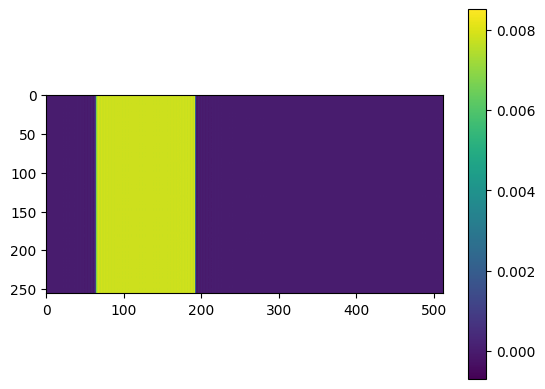

In [25]:
imshow(fft_rows_corrected)

In [26]:
badarray = kspace(256,1)

In [27]:
ifft = np.fft.ifftshift(np.fft.ifft(np.fft.fftshift(badarray), axis = 1))

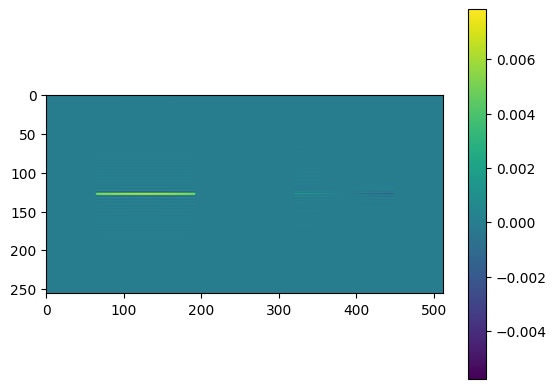

In [28]:
#zebra stripe pattern due to large shift in k-space which turned into a large phase ramp. 
#Atan2 method would be completely unreliable in this situation due to it being constrained between -pi and pi
imshow(ifft)

In [29]:
corrected_array = np.multiply(ifft,correction)

In [30]:
ifft_col = np.fft.ifftshift(np.fft.ifft(np.fft.fftshift(corrected_array), axis = 0))

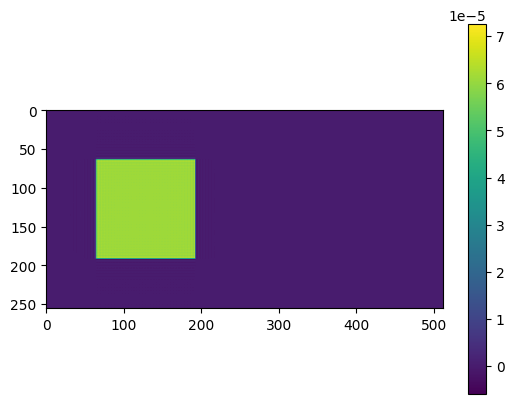

In [31]:
#ghost caused by different amounts of ringing in different parts of k-space
imshow(ifft_col)

In [32]:
ifft_bad = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(badarray)))

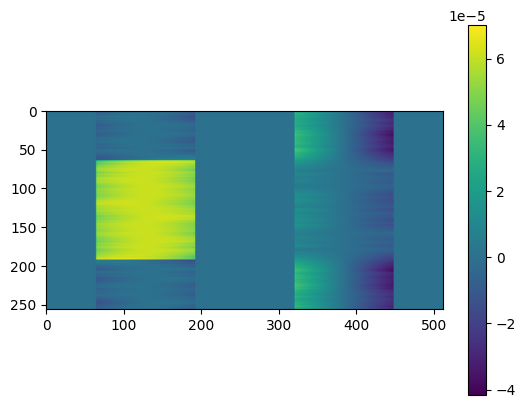

In [33]:
imshow(ifft_bad)